<h1>Higgs Boson Challenge</h1>
<img src="images/title.png" alt="Drawing" style="width: 350px;">

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from prepare import prepare_data
from model import Model
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import xgboost as xgb

<h1>The Problem</h1>

What we achieved
====

* Understanding of the experimental particle detection setup
* The meaning of the measurements
* Data visualization
* Training extreme gradient boosting models
* Training ensemble models in 24 hours is hard!

<h1>The Physics Behind It</h1>

Particles and pseudo-particles of interest to the challenge:<br>

**Electrons** and **muons** live long enough to reach the detector. <br>
Taus do not --> decay, decay products are summed and called the **Hadronic Tau** <br>
Taus decay into either: an electron and 2 neutrinos, a muon and two neutrinos, or charged particles and a neutrino. <br>
**Jets** are also pseudo-particles; they originate from a high energy quark or gluon; they appear in the detector as a collimated energy deposit.<br>
**Missing transverse energy** is another pseudo-particle?

The measured momentum of all the particles is provided. (See Special Relativity) <br>
z-axis is direction of beam. <br>
THETA is the polar angle. PHI is the azimuthal angle.<br>
The *pseudorapidity* is ETA = −ln tan(θ/2) <br>
<br>
Neutrinos from tau decay aren't detected. Usually they can be found using momentum conservation. But, a lot of information on particles produced from the collision are lost down the beam pipe, and there is experimental error, hence all the momentums cannot be fully accounted for. In the transverse direction (the x-y plane) we can account for all of the momentum, hence we can compute the _transverse energy_. <br>

Higgs decays into tau tau (and in 2018 observed to decay into two bottom quarks)<br>
Problems with measuring Higgs: The Z boson also decays into tau tau, and the neutrino is not measured (see above for problems with this).
<br>
<br>
What's a **lepton**? As far as we know, it's a fundamental particle of nature. There are two kinds -- charged and neutral -- which are subdivided into 3 'families' by rest mass: <br>
Charged leptons: electron, muon, tau<br>
Neutral  leptons: electron neutrino, muon neutrino, tau neutrino <br>
and their antiparticles.
<br>
<br>
The final state of Higgs decay, in our case, is simplified to a lepton (electron), a hadronic tau (because the tau decays before reaching the detector), and 3 neutrinos. The lepton is directly measured. The hadronic tau is -- as a pseudo-particle -- directly measured. But, for the neutrinos, all we have is the transverse missing energy (which is an _estimation_, and not even one with full info b/c of particles that are never seen going down the beam axis).
<br>
<br>
The positive (signal) class is comprised of events in which the Higgs boson decays
into two taus.
<br>
<br>
Why is this important?? Okay, so the SM predicts that the Higgs as a specific interaction (coupling) with fermions (quarks and leptons). We can infer from the probability of observing a Higgs boson (its cross-section), that the coupling with quarks is not very different from the prediction. But what about leptons? Neutrinos have small mass and can oscillate b/w forms (weird), so their mass might be governed by some other mechanism. But neutrinos interact only through the weak force because they are uncharged (and not quarks). Hence the importance of checking the interaction with charged leptons. CERN is not sufficiently sensitive to detect interactions b/w the Higgs boson and the electron or muon, hence we look at the tau. Hence we want the tau-tau interactions.
Message Input

Message jmenard, Nilou

<h1>The Statistical Model</h1>

Each collision event is characterized by a vector of measurements $\mathbf{x} \in \mathbb{R}^{30}$ (the feature vector). The event leads to two possible outcomes, either a Higgs boson or background noise were emitted. The outcomes are identified by a label vector $y \in \mathbb{B}$. The ultimate goal is to maximize the approximated median significance of the detection, given by:

$$
\text{AMS} = \sqrt{2 \left(s + b + b_{\text{reg}}\right) \log \left(1 + \frac{s}{b + b_{\text{reg}}}\right) - s},
$$

where $s$ and $b$ are the unbiased estimators of the average number of Higgs bosons emmisions and background noise detection

<h1>Our Solution</h1>

In [2]:
DATA_PATH = "./atlas-higgs-challenge-2014-v2.csv"

df, X_train, y_train, W_train, X_val, y_val, W_val, X_test, y_test, W_test = prepare_data(DATA_PATH)

In [3]:
print("Number of Features: {0}".format(X_train.shape[1]))
print("Number of train samples: {0}".format(X_train.shape[0]))
print("Number of validation samples: {0}".format(X_val.shape[0]))
print("Number of test samples: {0}".format(X_test.shape[0]))

Number of Features: 30
Number of train samples: 250000
Number of validation samples: 100000
Number of test samples: 450000


In [53]:
scale_pos_weight = (y_train[y_train["Label"]==1].count()/y_train[y_train["Label"]==0].count()).values[0]
evals_result = {}
params = {'max_depth': 10, 'eta': 0.01, 'gamma': 0.8,
          'subsample': 0.6, 'eval_metric': ['auc', 'error'],
          'lambda': 25, 'growth_policy': 'depthwise', 'silent': 1, 
          'objective': 'binary:logistic', 'scale_pos_weight': scale_pos_weight}
model = Model(params)

In [54]:
model.fit(X_train, y_train, X_val, y_val, num_rounds=100)
y_pred = model.predict(X_train)

[0]	train-auc:0.873766	train-error:0.183104	eval-auc:0.868432	eval-error:0.19077
[1]	train-auc:0.877543	train-error:0.179032	eval-auc:0.872288	eval-error:0.1866
[2]	train-auc:0.880386	train-error:0.179528	eval-auc:0.874906	eval-error:0.18637
[3]	train-auc:0.881241	train-error:0.178512	eval-auc:0.875952	eval-error:0.18521
[4]	train-auc:0.884951	train-error:0.177744	eval-auc:0.879437	eval-error:0.18427
[5]	train-auc:0.886135	train-error:0.177872	eval-auc:0.880627	eval-error:0.18392
[6]	train-auc:0.887131	train-error:0.177712	eval-auc:0.881667	eval-error:0.18378
[7]	train-auc:0.887181	train-error:0.177796	eval-auc:0.881711	eval-error:0.18404
[8]	train-auc:0.887261	train-error:0.177004	eval-auc:0.881853	eval-error:0.18348
[9]	train-auc:0.88753	train-error:0.176856	eval-auc:0.882135	eval-error:0.18339
[10]	train-auc:0.887804	train-error:0.176764	eval-auc:0.882372	eval-error:0.18336
[11]	train-auc:0.888213	train-error:0.176808	eval-auc:0.882766	eval-error:0.18296
[12]	train-auc:0.888708	trai

In [55]:
model.score(W_train, y_pred, y_train, 0.6)

1.9495296386594314

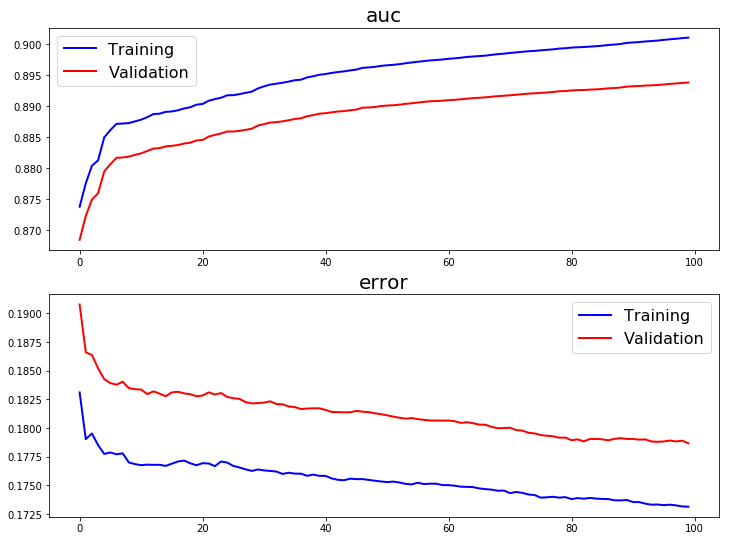

In [56]:
model.plot_evals_result()

In [58]:
interact(model.plot_histogram, cutoff=(0.1,0.95,0.05), 
          W=fixed(W_train), X_train=fixed(X_train), y_train=fixed(y_train))

interactive(children=(FloatSlider(value=0.5, description='cutoff', max=0.95, min=0.1, step=0.05), Output()), _…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

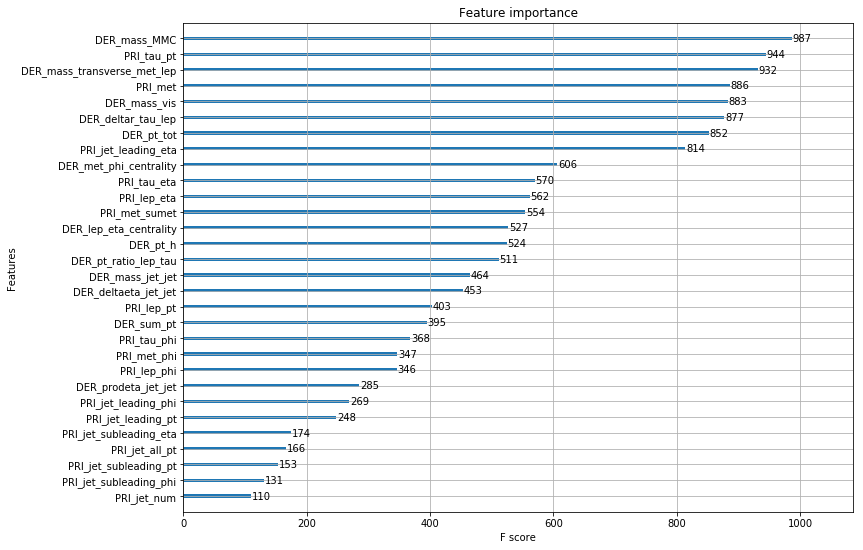

In [9]:
model.plot_importance()

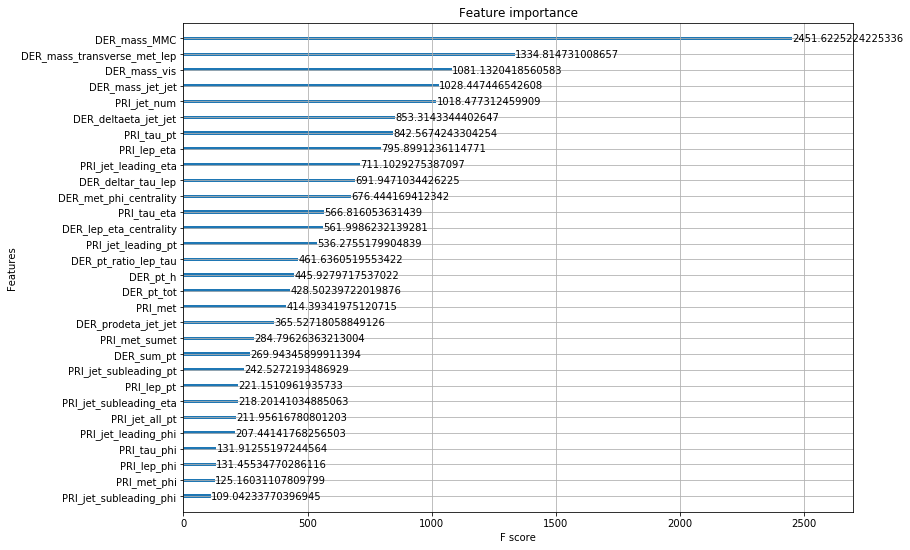

In [10]:
model.plot_importance(importance_type="cover")

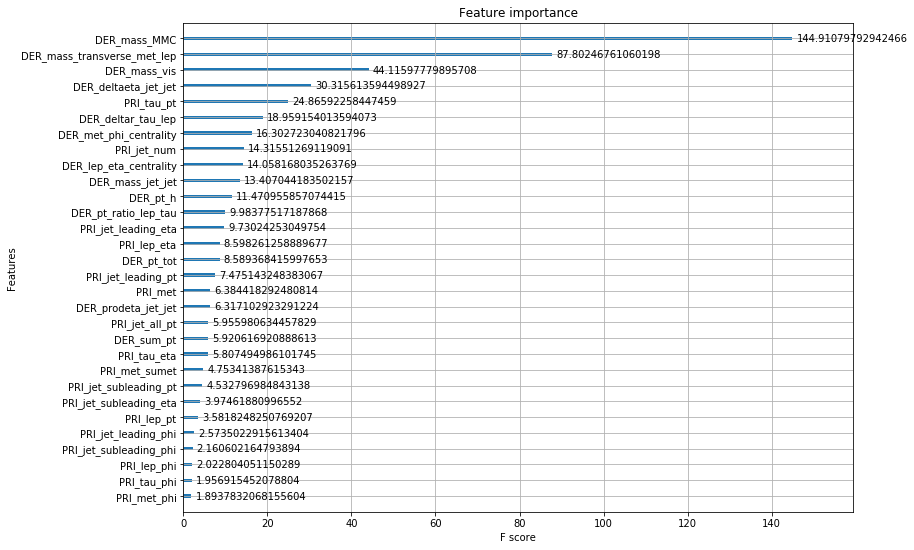

In [11]:
model.plot_importance(importance_type="gain")